## 1. Setup and Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Import acoustic model functions
import sys
sys.path.append('Acoustic')
from acoustic_function import (
    initialize_acoustic_model,
    state_transition,
    observation_model,
    compute_observation_jacobian,
    simulate_trajectory
)

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.20.0
GPU available: False


## 2. Initialize Acoustic Model

We use the acoustic_function.py module which provides:
- `initialize_acoustic_model()`: Sets up all parameters
- `state_transition()`: Linear motion model $x_k = \Phi x_{k-1} + w_k$
- `observation_model()`: Nonlinear acoustic measurements
- `compute_observation_jacobian()`: Computes $H = \frac{\partial h}{\partial x}$
- `simulate_trajectory()`: Generates ground truth data

In [2]:
# Initialize acoustic model with default parameters (4 targets, 25 sensors)
model_params = initialize_acoustic_model(n_targets=4)

print(f"Configuration:")
print(f"  Targets: {model_params['n_targets']}")
print(f"  Sensors: {model_params['n_sensors']} (5×5 grid)")
print(f"  State dimension: {model_params['state_dim']}")
print(f"  Surveillance area: {model_params['sim_area_size']}m × {model_params['sim_area_size']}m")
print(f"\nAcoustic Parameters:")
print(f"  Amplitude (Ψ): {model_params['amplitude'].numpy()}")
print(f"  Measurement noise std: {model_params['measurement_noise_std']}")

Configuration:
  Targets: 4
  Sensors: 25 (5×5 grid)
  State dimension: 16
  Surveillance area: 40.0m × 40.0m

Acoustic Parameters:
  Amplitude (Ψ): 10.0
  Measurement noise std: 0.1


In [3]:
class EDHFilter:
    """
    Exact Daum-Huang Particle Filter.
    
    Implementation follows:
    - Algorithm 1 & 2 from Ding & Coates (2012)
    - MATLAB code: DH_ExactFlow_Filter.m
    
    CORRECTED: Now properly implements both covariance computations:
    - Line 6: P_{k|k-1} (prediction covariance) 
    - Line 17: P_{k|k} (update covariance)
    """
    
    def __init__(self, model_params, n_particle=100, n_lambda=20, lambda_ratio=1.2, use_local=True):
        """
        Args:
            model_params: Dictionary from initialize_acoustic_model()
            n_particle: Number of particles
            n_lambda: Number of lambda steps (default: 20)
            lambda_ratio: Ratio for exponential spacing (default: 1.2)
            use_local: If True, use local linearization (Modified Algorithm)
                      If False, use global linearization (Original Algorithm)
        """
        self.model_params = model_params
        self.n_particle = n_particle
        self.n_lambda = n_lambda
        self.lambda_ratio = lambda_ratio
        self.use_local = use_local
        
        # Compute lambda steps with exponential spacing
        self._compute_lambda_steps()
        
        print(f"EDH Filter Configuration:")
        print(f"  Particles: {n_particle}")
        print(f"  Lambda steps: {n_lambda}")
        print(f"  Lambda ratio: {lambda_ratio}")
        print(f"  Local linearization: {use_local}")
    
    def _compute_lambda_steps(self):
        """
        Compute exponentially spaced lambda steps.
        
        Step sizes: ε_j = ε_1 * q^(j-1)
        Constraint: Σ ε_j = 1
        
        Solution: ε_1 = (1-q)/(1-q^n)
        """
        q = self.lambda_ratio
        n = self.n_lambda
        
        # Initial step size
        epsilon_1 = (1 - q) / (1 - q**n)
        
        # Step sizes: ε_j = ε_1 * q^(j-1) for j=1,...,n
        step_sizes = [epsilon_1 * (q**j) for j in range(n)]
        self.lambda_steps = tf.constant(step_sizes, dtype=tf.float32)
        
        # Cumulative lambda values: λ_j = Σ_{i=1}^j ε_i
        self.lambda_values = tf.cumsum(self.lambda_steps)
        
        print(f"\nLambda steps (first 5): {self.lambda_steps[:5].numpy()}")
        print(f"Lambda values (last 5): {self.lambda_values[-5:].numpy()}")
        print(f"Sum of steps: {tf.reduce_sum(self.lambda_steps).numpy():.6f}")
    
    def initialize_particles(self):
        """
        Initialize particles from Gaussian distribution.
        
        Algorithm Line 1-2
        
        Returns:
            particles: (state_dim, n_particle)
            P: Initial covariance P_0
        """
        state_dim = self.model_params['state_dim']
        x0 = self.model_params['x0_initial_target_states']  # (state_dim, 1)
        
        # Initial uncertainty (from paper)
        sigma0_single = tf.constant([2.0, 2.0, 0.5, 0.5], dtype=tf.float32)  # Per target
        sigma0 = tf.tile(sigma0_single, [self.model_params['n_targets']])
        P0 = tf.linalg.diag(tf.square(sigma0))
        
        # Sample particles: x ~ N(x0, P0)
        noise = tf.random.normal((state_dim, self.n_particle), dtype=tf.float32)
        particles = x0 + tf.expand_dims(sigma0, 1) * noise
        
        return particles, P0
    
    def propagate_particles(self, particles):
        """
        Propagate particles: x_k = Φ * x_{k-1} + w_k
        
        Algorithm Line 4
        MATLAB: DH_ExactFlow_Filter.m line 63
        
        Args:
            particles: (state_dim, n_particle)
        Returns:
            particles_pred: (state_dim, n_particle)
        """
        state_dim = self.model_params['state_dim']
        Phi = self.model_params['Phi']
        Q = self.model_params['Q']  # Use filter noise (larger)
        
        # Linear propagation
        particles_pred = tf.matmul(Phi, particles)
        
        # Add process noise
        Q_chol = tf.linalg.cholesky(Q)
        noise = tf.matmul(Q_chol, tf.random.normal((state_dim, self.n_particle), dtype=tf.float32))
        
        return particles_pred + noise
    
    def estimate_covariance(self, particles):
        """
        Estimate covariance from particles.
        
        P = (1/(N-1)) * Σ (x_i - x̄)(x_i - x̄)^T
        
        Used for both:
        - Algorithm Line 6: P_{k|k-1} (prediction)
        - Algorithm Line 17: P_{k|k} (update)
        
        MATLAB: cov(particles') in lines 53, 67, 119
        
        Args:
            particles: (state_dim, n_particle)
        Returns:
            P: (state_dim, state_dim)
        """
        mean = tf.reduce_mean(particles, axis=1, keepdims=True)
        centered = particles - mean
        n_particles = tf.cast(tf.shape(particles)[1], tf.float32)
        P = tf.matmul(centered, tf.transpose(centered)) / (n_particles - 1.0)
        
        # Add small regularization for numerical stability
        P = P + 1e-6 * tf.eye(tf.shape(P)[0], dtype=tf.float32)
        return P
    
    def compute_flow_parameters(self, x, x_bar, P, measurement, lam):
        """
        Compute flow parameters A and b for particle x.
        
        Algorithm Line 10
        MATLAB: calculateSlope() function
        
        Flow equations:
            A(λ) = -1/2 * P * H^T * (λ*H*P*H^T + R)^{-1} * H
            b(λ) = (I + 2λA) * [(I + λA) * P*H^T*R^{-1}*(z-e) + A*x̄]
        
        Args:
            x: Particle position (state_dim, 1) - used for linearization
            x_bar: Mean trajectory (state_dim, 1) - used in b
            P: Covariance (state_dim, state_dim) - should be P_{k|k-1}
            measurement: z (n_sensor, 1)
            lam: Current lambda value (scalar)
        Returns:
            A: (state_dim, state_dim)
            b: (state_dim,)
        """
        state_dim = tf.shape(P)[0]
        R = self.model_params['R']
        
        # Algorithm Line 9: Linearize at x (local) or x_bar (global)
        linearization_point = x if self.use_local else x_bar
        
        # Compute Jacobian H = ∂h/∂x at linearization point
        H = compute_observation_jacobian(linearization_point, self.model_params)
        
        # Compute h(x̄) and linearization residual e = h(x̄) - H*x̄
        h_x_bar = observation_model(x_bar, self.model_params)
        h_x_bar = tf.squeeze(h_x_bar, axis=1)  # (n_sensor,)
        e = h_x_bar - tf.linalg.matvec(H, tf.squeeze(x_bar, axis=1))
        
        # Compute H*P*H^T
        HPHt = tf.matmul(tf.matmul(H, P), tf.transpose(H))
        
        # Innovation covariance: S = λ*H*P*H^T + R
        S = lam * HPHt + R
        S_inv = tf.linalg.inv(S)
        
        # Compute P*H^T
        PHt = tf.matmul(P, tf.transpose(H))
        
        # Flow matrix A = -0.5 * P*H^T * S^{-1} * H
        A = -0.5 * tf.matmul(tf.matmul(PHt, S_inv), H)
        
        # Innovation: z - e
        innovation = tf.squeeze(measurement, axis=1) - e
        
        # Compute R^{-1}*(z - e)
        R_inv = tf.linalg.inv(R)
        R_inv_innov = tf.linalg.matvec(R_inv, innovation)
        
        # Identity matrix
        I = tf.eye(state_dim, dtype=tf.float32)
        
        # (I + λA)
        I_plus_lam_A = I + lam * A
        
        # First term: (I + λA) * P*H^T * R^{-1}*(z - e)
        term1 = tf.linalg.matvec(tf.matmul(I_plus_lam_A, PHt), R_inv_innov)
        
        # Second term: A * x̄
        term2 = tf.linalg.matvec(A, tf.squeeze(x_bar, axis=1))
        
        # (I + 2λA)
        I_plus_2lam_A = I + 2 * lam * A
        
        # Flow vector b = (I + 2λA) * [term1 + term2]
        b = tf.linalg.matvec(I_plus_2lam_A, term1 + term2)
        
        return A, b
    
    def particle_flow(self, particles, measurement, P_pred):
        """
        Migrate particles from prior to posterior using exact flow.
        
        Algorithm Lines 7-16
        MATLAB: DH_ExactFlow_Filter.m lines 78-101
        
        Args:
            particles: Predicted particles (state_dim, n_particle)
            measurement: Current measurement (n_sensor, 1)
            P_pred: Prior covariance P_{k|k-1} (state_dim, state_dim)
        Returns:
            particles_flowed: Updated particles (state_dim, n_particle)
        """
        # Initialize flow
        eta = tf.identity(particles)  # Current particle positions
        eta_bar = tf.reduce_mean(particles, axis=1, keepdims=True)  # Mean trajectory
        
        # Use provided prior covariance P_{k|k-1} for flow computation
        # MATLAB: Uses vg.PP (predicted covariance) throughout the lambda loop
        P = P_pred
        
        # Algorithm Line 7: Flow particles through lambda steps
        for j in range(self.n_lambda):
            epsilon_j = self.lambda_steps[j]  # Step size
            lambda_j = self.lambda_values[j]  # Current lambda value
            
            if self.use_local:
                # Modified Algorithm 2: Local linearization at each particle
                # MATLAB: Algorithm 2, lines 9-13
                slopes = []
                for i in range(self.n_particle):
                    x_i = tf.expand_dims(eta[:, i], 1)  # (state_dim, 1)
                    
                    # Algorithm Line 10-11: Compute flow parameters for this particle
                    A_i, b_i = self.compute_flow_parameters(x_i, eta_bar, P, measurement, lambda_j)
                    
                    # Algorithm Line 12: Compute slope: dx/dλ = A*x + b
                    slope_i = tf.linalg.matvec(A_i, tf.squeeze(x_i)) + b_i
                    slopes.append(slope_i)
                
                slopes = tf.stack(slopes, axis=1)  # (state_dim, n_particle)
            else:
                # Original Algorithm 1: Global linearization at mean
                # MATLAB: Algorithm 1, lines 9-13
                A, b = self.compute_flow_parameters(eta_bar, eta_bar, P, measurement, lambda_j)
                slopes = tf.matmul(A, eta) + tf.expand_dims(b, 1)
            
            # Algorithm Line 13: Euler update: x = x + ε * (dx/dλ)
            # MATLAB: line 98
            eta = eta + epsilon_j * slopes
            
            # Algorithm Line 15: Update mean trajectory
            # MATLAB: line 99
            eta_bar = tf.reduce_mean(eta, axis=1, keepdims=True)
        
        return eta
    
    def filter_step(self, particles, measurement):
        """
        Perform one EDH filter step.
        
        Args:
            particles: Current particles (state_dim, n_particle)
            measurement: Current measurement (n_sensor, 1)
        Returns:
            particles_updated: Updated particles
            mean_estimate: Mean state estimate
            P_updated: Updated covariance P_{k|k}
        """
        # Algorithm Line 4: PREDICTION - Propagate particles
        # MATLAB: line 63
        particles_pred = self.propagate_particles(particles)
        
        # Algorithm Line 6: Compute P_{k|k-1} (prior/predicted covariance)
        # MATLAB: lines 44-54 (ekf_predict1/ukf_predict1 or cov(xp_tmp'))
        P_pred = self.estimate_covariance(particles_pred)
        
        # Algorithm Lines 7-16: UPDATE - Particle flow from prior to posterior
        # Uses P_{k|k-1} throughout the flow
        # MATLAB: lines 78-101
        particles_flowed = self.particle_flow(particles_pred, measurement, P_pred)
        
        # Algorithm Line 17: Compute P_{k|k} (posterior/updated covariance)
        # MATLAB: lines 113-120 (ekf_update1/ukf_update1 or cov(vg.xp'))
        P_updated = self.estimate_covariance(particles_flowed)
        
        # Algorithm Line 18: ESTIMATE - Compute mean
        # MATLAB: line 108
        mean_estimate = tf.reduce_mean(particles_flowed, axis=1)
        
        return particles_flowed, mean_estimate, P_updated
    
    def run_filter(self, measurements):
        """
        Run EDH filter on measurement sequence.
        
        Args:
            measurements: Measurements (n_sensor, T)
        Returns:
            estimates: State estimates (state_dim, T)
            particles_all: Particles over time (state_dim, n_particle, T)
            covariances_all: Covariances P_{k|k} over time (state_dim, state_dim, T)
        """
        T = tf.shape(measurements)[1].numpy()
        
        # Algorithm Lines 1-2: Initialize particles and covariance
        particles, P = self.initialize_particles()
        
        # Storage
        estimates_list = []
        particles_list = []
        covariances_list = []
        
        # Algorithm Line 3: Run filter for k = 1 to T
        for t in range(T):
            z_t = tf.expand_dims(measurements[:, t], 1)  # (n_sensor, 1)
            
            # Filter step - includes Lines 4, 6, 7-16, 17, 18
            particles, mean_estimate, P = self.filter_step(particles, z_t)
            
            # Store results
            estimates_list.append(tf.expand_dims(mean_estimate, 1))
            particles_list.append(tf.expand_dims(particles, 2))
            covariances_list.append(tf.expand_dims(P, 2))
        
        estimates = tf.concat(estimates_list, axis=1)
        particles_all = tf.concat(particles_list, axis=2)
        covariances_all = tf.concat(covariances_list, axis=2)
        
        return estimates, particles_all, covariances_all

In [4]:
q = 1.2
n = 3

## IMPORTANT CORRECTION: Dual Covariance Computation

The previous implementation had a **critical issue**: it only computed covariance **once** during the particle flow, but Algorithm 1 specifies **two** covariance computations per time step:

### Algorithm 1 Requirements:

| Line | When | What | Purpose |
|------|------|------|---------|
| **6** | After prediction | `P_{k\|k-1}` | **Prior covariance** - used during particle flow |
| **17** | After update | `P_{k\|k}` | **Posterior covariance** - for next iteration |

### What Was Wrong:

```python
# OLD (INCORRECT):
def particle_flow(self, particles, measurement):
    P = self.estimate_covariance(particles)  # Only computed ONCE
    # ... flow uses this P ...
    return particles

def filter_step(self, particles, measurement):
    particles_pred = self.propagate_particles(particles)
    particles_flowed = self.particle_flow(particles_pred, measurement)
    # MISSING: No P_{k|k} computation!
    return particles_flowed, mean_estimate
```

### What Is Correct Now:

```python
# NEW (CORRECT):
def particle_flow(self, particles, measurement, P_pred):
    P = P_pred  # Uses provided P_{k|k-1}
    # ... flow uses this P ...
    return particles

def filter_step(self, particles, measurement):
    particles_pred = self.propagate_particles(particles)
    P_pred = self.estimate_covariance(particles_pred)       # Line 6: P_{k|k-1}
    particles_flowed = self.particle_flow(particles_pred, measurement, P_pred)
    P_updated = self.estimate_covariance(particles_flowed)  # Line 17: P_{k|k}
    return particles_flowed, mean_estimate, P_updated
```

### Why This Matters:

1. **P_{k|k-1}** captures uncertainty **after** motion but **before** measurement update
2. **P_{k|k}** captures uncertainty **after** incorporating measurement information  
3. Using the wrong covariance matrix affects the flow dynamics and filter accuracy
4. The covariance evolution: P_{k-1|k-1} → P_{k|k-1} (grows) → P_{k|k} (shrinks with measurement)

This correction makes the Python implementation **faithful** to the MATLAB reference code.

## 3. Generate Ground Truth Data

Use the acoustic_function.py to generate realistic trajectories and measurements.

In [5]:
# Generate ground truth trajectory and measurements
T = 30  # Number of time steps

print(f"Generating ground truth trajectory ({T} time steps)...")
ground_truth, measurements = simulate_trajectory(model_params, T, keep_in_bounds=True)

print(f"Ground truth shape: {ground_truth.shape}")
print(f"Measurements shape: {measurements.shape}")

Generating ground truth trajectory (30 time steps)...
Ground truth shape: (16, 31)
Measurements shape: (25, 30)


## 4. Visualize Setup

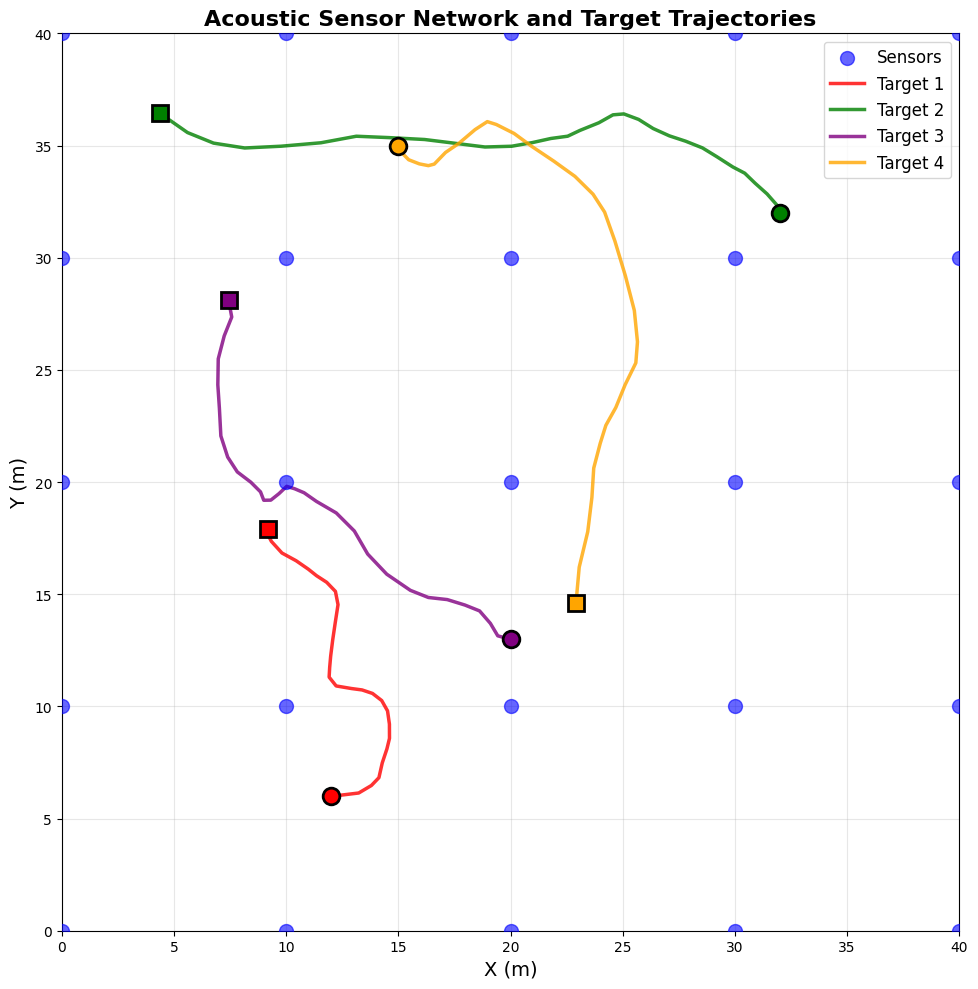

Circle = Start position
Square = End position


In [6]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot sensors
sensors = model_params['sensor_positions'].numpy()
ax.scatter(sensors[:, 0], sensors[:, 1], 
          c='blue', marker='o', s=100, label='Sensors', alpha=0.6, zorder=5)

# Plot true trajectories
colors = ['red', 'green', 'purple', 'orange']
gt = ground_truth.numpy()

for i in range(model_params['n_targets']):
    x_idx = i * 4
    y_idx = i * 4 + 1
    
    x_true = gt[x_idx, :]
    y_true = gt[y_idx, :]
    
    ax.plot(x_true, y_true, '-', color=colors[i], linewidth=2.5,
           label=f'Target {i+1}', markersize=6, alpha=0.8)
    
    # Mark start and end
    ax.plot(x_true[0], y_true[0], 'o', color=colors[i], 
           markersize=12, markeredgecolor='black', markeredgewidth=2)
    ax.plot(x_true[-1], y_true[-1], 's', color=colors[i], 
           markersize=12, markeredgecolor='black', markeredgewidth=2)

ax.set_xlabel('X (m)', fontsize=14)
ax.set_ylabel('Y (m)', fontsize=14)
ax.set_title('Acoustic Sensor Network and Target Trajectories', fontsize=16, fontweight='bold')
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, model_params['sim_area_size']])
ax.set_ylim([0, model_params['sim_area_size']])
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print("Circle = Start position")
print("Square = End position")

## 5. Run EDH Filter

Now we run the EDH filter with local linearization.

In [7]:
# Initialize EDH filter with local linearization
edh_filter = EDHFilter(
    model_params,
    n_particle=100,
    n_lambda=20,
    lambda_ratio=1.2,
    use_local=False
)

print(f"\nRunning EDH filter...")
print("This may take a minute...\n")

# Run filter - now returns 3 values: estimates, particles, covariances
edh_estimates, edh_particles, edh_covariances = edh_filter.run_filter(measurements)

print(f"EDH estimates shape: {edh_estimates.shape}")
print(f"EDH particles shape: {edh_particles.shape}")
print(f"EDH covariances shape: {edh_covariances.shape}")
print("EDH filter completed successfully!")
print(f"\nNote: Covariances are now properly computed twice per time step:")
print(f"  - P_{{k|k-1}} (prediction) used during particle flow")
print(f"  - P_{{k|k}} (update) stored and used for next iteration")


Lambda steps (first 5): [0.00535653 0.00642784 0.0077134  0.00925609 0.0111073 ]
Lambda values (last 5): [0.4683864  0.56742024 0.6862608  0.8288695  1.        ]
Sum of steps: 1.000000
EDH Filter Configuration:
  Particles: 100
  Lambda steps: 20
  Lambda ratio: 1.2
  Local linearization: False

Running EDH filter...
This may take a minute...

EDH estimates shape: (16, 30)
EDH particles shape: (16, 100, 30)
EDH covariances shape: (16, 16, 30)
EDH filter completed successfully!

Note: Covariances are now properly computed twice per time step:
  - P_{k|k-1} (prediction) used during particle flow
  - P_{k|k} (update) stored and used for next iteration


## 6. Visualize Results

/var/folders/fr/7vt2v5bs1f37tzqpnrrq0l880000gn/T/ipykernel_48779/1089041948.py:25: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take precedence.
  ax.plot(x_est, y_est, '--', color=colors[i], linewidth=2.5,


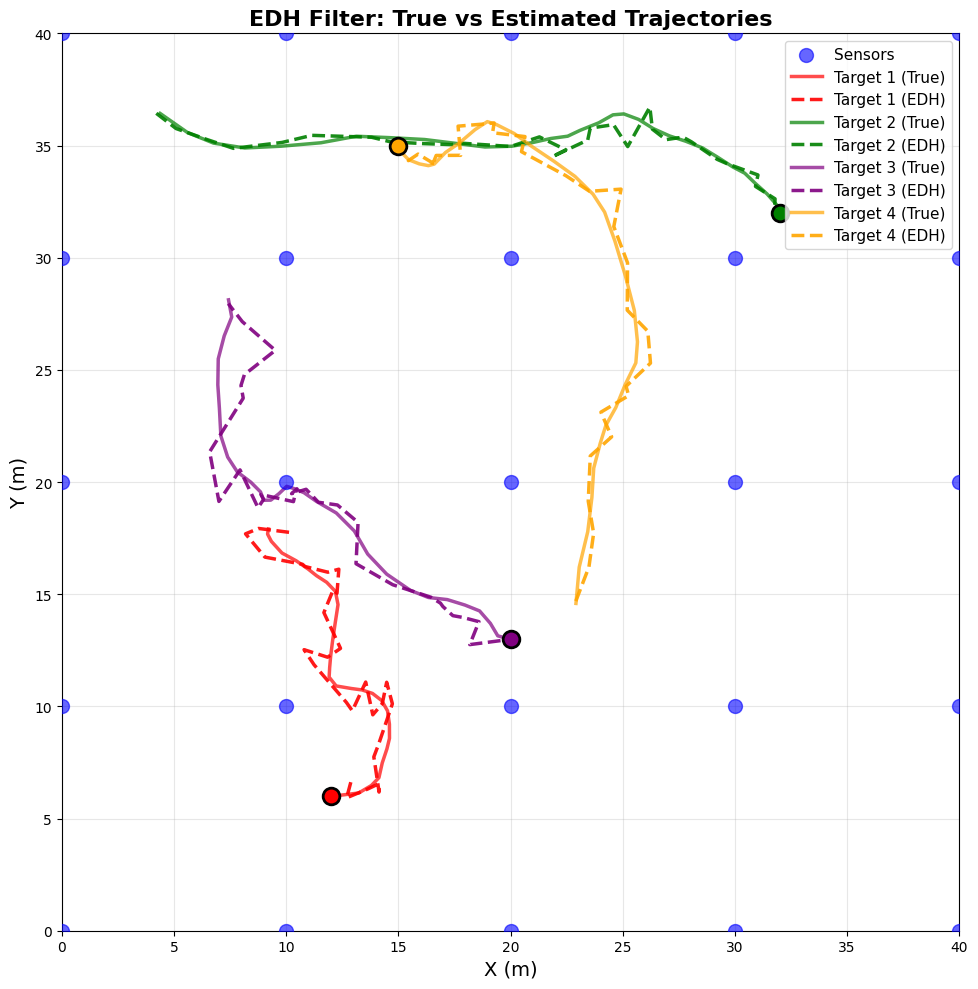

In [8]:
# Plot estimated trajectories
fig, ax = plt.subplots(figsize=(11, 10))

# Plot sensors
ax.scatter(sensors[:, 0], sensors[:, 1], 
          c='blue', marker='o', s=100, label='Sensors', alpha=0.6, zorder=5)

colors = ['red', 'green', 'purple', 'orange']
gt = ground_truth.numpy()
est = edh_estimates.numpy()

for i in range(model_params['n_targets']):
    x_idx = i * 4
    y_idx = i * 4 + 1
    
    # Ground truth
    x_true = gt[x_idx, :]
    y_true = gt[y_idx, :]
    ax.plot(x_true, y_true, '-', color=colors[i], linewidth=2.5,
           label=f'Target {i+1} (True)', alpha=0.7)
    
    # Estimates
    x_est = est[x_idx, :]
    y_est = est[y_idx, :]
    ax.plot(x_est, y_est, '--', color=colors[i], linewidth=2.5,
           label=f'Target {i+1} (EDH)', alpha=0.9, linestyle='dashed')
    
    # Mark start
    ax.plot(x_true[0], y_true[0], 'o', color=colors[i], 
           markersize=12, markeredgecolor='black', markeredgewidth=2)

ax.set_xlabel('X (m)', fontsize=14)
ax.set_ylabel('Y (m)', fontsize=14)
ax.set_title('EDH Filter: True vs Estimated Trajectories', fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, model_params['sim_area_size']])
ax.set_ylim([0, model_params['sim_area_size']])
ax.set_aspect('equal')

plt.tight_layout()
plt.show()